# Entropy in shallow (fixed depth) random 2D circuit

2D architecture with local 2-site gates applied for fixed time, reduced to a $m \times n$ ring of width $2d$

In [2]:
import numpy as np
import math
import tensornetwork as tn
from scipy.stats import unitary_group as ug
from ast import literal_eval
from operator import itemgetter

In [36]:
# TODO: consider simplified calculation based on Clifford gate set?

def random_2d_mps_bound(m,n,d,q=2):
    """
    Generates a MPS representation of the boundary of a m x n region of qudits with local dimension q after applying a local random circuit. Depth cannot exceed size of circuit.
    Returns dictionary of MPS nodes labeled by coordinate, qudit indices labeled by coordinate, list of edges for each of four cycles, list of layers of gates labeled by qudit, and dictionary of boundary condition nodes. 
    Coordinates for boundary of ring run from (0,0) to (m,n). MPS node axes 0-3 are Schmidt indices, and axis 4 is qudit indices.
    """
    inner = [0,0,m,n]
    outer = [-1,-1,m+1,n+1]
    # check if circuit is sufficiently shallow
    if (m < 4*d-2 or n < 4*d-2):
        print('Error: circuit depth is greater than size of area')
        return {}, {}, [], [], {}
    
    # initiate interior and exterior region
    mps = dict(zip([(i,0) for i in range(m)],[prod_state_node((1,1,1,1),q,name=str((i,0))) for i in range(m)]))
    mps.update(dict(zip([(m,i) for i in range(n)],[prod_state_node((1,1,1,1),q,name=str((m,i))) for i in range(n)])))
    mps.update(dict(zip([(m-i,n) for i in range(m)],[prod_state_node((1,1,1,1),q,name=str((m-i,n))) for i in range(m)])))
    mps.update(dict(zip([(0,n-i) for i in range(n)],[prod_state_node((1,1,1,1),q,name=str((0,n-i))) for i in range(n)])))
    mps.update(dict(zip([(i-1,-1) for i in range(m+2)],[prod_state_node((1,1,1,1),q,name=str((i-1,-1))) for i in range(m+2)])))
    mps.update(dict(zip([(m+1,i-1) for i in range(n+2)],[prod_state_node((1,1,1,1),q,name=str((m+1,i-1))) for i in range(n+2)])))
    mps.update(dict(zip([(m-i+1,n+1) for i in range(m+2)],[prod_state_node((1,1,1,1),q,name=str((m-i+1,n+1))) for i in range(m+2)])))
    mps.update(dict(zip([(-1,n-i+1) for i in range(n+2)],[prod_state_node((1,1,1,1),q,name=str((-1,n-i+1))) for i in range(n+2)])))
    qubits = {coord:mps[coord][-1] for coord in mps}
    edges = [[],[],[],[]]
    edges[1] += [mps[(i-1,0)][0]^mps[(i-1,-1)][2] for i in range(m+3)] #using list += doesn't allocate new object in memory but list = does
    edges[0] += [mps[(0,i-1)][3]^mps[(-1,i-1)][1] for i in range(n+3)]
    edges[2*((m+1)%2)] += [mps[(m+1,i-1)][3]^mps[(m,i-1)][1] for i in range(n+3)]
    edges[2*((n+1)%2)+1] += [mps[(i-1,n+1)][0]^mps[(i-1,n)][2] for i in range(m+3)]
    edges[0] += [mps[(2*i+2,-1)][3]^mps[(2*i+1,-1)][1] for i in range(m//2)]+[mps[(2*i+2,0)][3]^mps[(2*i+1,0)][1] for i in range(m//2)]
    edges[0] += [mps[(2*i+2,n)][3]^mps[(2*i+1,n)][1] for i in range(m//2)]+[mps[(2*i+2,n+1)][3]^mps[(2*i+1,n+1)][1] for i in range(m//2)]
    edges[2] += [mps[(2*i+1,-1)][3]^mps[(2*i,-1)][1] for i in range((m+1)//2)]+[mps[(2*i+1,0)][3]^mps[(2*i,0)][1] for i in range((m+1)//2)]
    edges[2] += [mps[(2*i+1,n)][3]^mps[(2*i,n)][1] for i in range((m+1)//2)]+[mps[(2*i+1,n+1)][3]^mps[(2*i,n+1)][1] for i in range((m+1)//2)]
    edges[1] += [mps[(-1,2*i+2)][0]^mps[(-1,2*i+1)][2] for i in range(n//2)]+[mps[(0,2*i+2)][0]^mps[(0,2*i+1)][2] for i in range(n//2)]
    edges[1] += [mps[(n,2*i+2)][0]^mps[(n,2*i+1)][2] for i in range(n//2)]+[mps[(n+1,2*i+2)][0]^mps[(n+1,2*i+1)][2] for i in range(n//2)]
    edges[3] += [mps[(-1,2*i+1)][0]^mps[(-1,2*i)][2] for i in range((n+1)//2)]+[mps[(0,2*i+1)][0]^mps[(0,2*i)][2] for i in range((n+1)//2)]
    edges[3] += [mps[(n,2*i+1)][0]^mps[(n,2*i)][2] for i in range((n+1)//2)]+[mps[(n+1,2*i+1)][0]^mps[(n+1,2*i)][2] for i in range((n+1)//2)]
    ops = []
        
    # generate random circuit
    for t in range(d):
        layer = []
        for j in [0,1,2,3]:
            c = {}
            # add necessary edges
            if (j == 0):
                if (t == 0) and (m%2):
                    mps.update(dict(zip([(m+2,i-1) for i in range(n+3)],[prod_state_node((1,1,1,1),q,name=str((m+2,i-1))) for i in range(n+3)])))
                    qubits.update({coord:mps[coord][-1] for coord in [(m+2,i-1) for i in range(n+3)]})
                    edges[0] += [mps[(m+2,i-1)][3]^mps[(m+1,i-1)][1] for i in range(n+3)]
                    edges[1] += [mps[(m+2,i+1)][0]^mps[(m+2,i)][2] for i in range(-1,n+1,2)]
                    edges[3] += [mps[(m+2,i+1)][0]^mps[(m+2,i)][2] for i in range(0,n+1,2)]
                    outer[2] += 1
                    mps.update(dict(zip([(m-1,i+1) for i in range(n-1)],[prod_state_node((1,1,1,1),q,name=str((m-1,i+1))) for i in range(n-1)])))
                    qubits.update({coord:mps[coord][-1] for coord in [(m-1,i+1) for i in range(n-1)]})
                    edges[0] += [mps[(m,i+1)][3]^mps[(m-1,i+1)][1] for i in range(n-1)]
                    edges[1] += [mps[(m-1,i+1)][0]^mps[(m-1,i)][2] for i in range(1,n,2)]
                    edges[3] += [mps[(m-1,i+1)][0]^mps[(m-1,i)][2] for i in range(0,n,2)]
                    inner[2] -= 1
                elif (t > 0):
                    h = outer[-1]-outer[1]
                    mps.update(dict(zip([(outer[0]-1,outer[1]+i) for i in range(h+1)],[prod_state_node((1,1,1,1),q,name=str((outer[0]-1,outer[1]+i))) for i in range(h+1)])))
                    mps.update(dict(zip([(outer[2]+1,outer[1]+i) for i in range(h+1)],[prod_state_node((1,1,1,1),q,name=str((outer[2]+1,outer[1]+i))) for i in range(h+1)])))
                    qubits.update({coord:mps[coord][-1] for coord in [(outer[0]-1,outer[1]+i) for i in range(h+1)]})
                    qubits.update({coord:mps[coord][-1] for coord in [(outer[2]+1,outer[1]+i) for i in range(h+1)]})
                    edges[0] += [mps[(outer[2]+1,outer[1]+i)][3]^mps[(outer[2],outer[1]+i)][1] for i in range(h+1)]
                    edges[0] += [mps[(outer[0],outer[1]+i)][3]^mps[(outer[0]-1,outer[1]+i)][1] for i in range(h+1)]
                    edges[1] += [mps[(outer[2]+1,i+1)][0]^mps[(outer[2]+1,i)][2] for i in range(outer[0]+1,outer[-1],2)]
                    edges[1] += [mps[(outer[0]-1,i+1)][0]^mps[(outer[0]-1,i)][2] for i in range(outer[0]+1,outer[-1],2)]
                    edges[3] += [mps[(outer[2]+1,i+1)][0]^mps[(outer[2]+1,i)][2] for i in range(outer[0],outer[-1],2)]
                    edges[3] += [mps[(outer[0]-1,i+1)][0]^mps[(outer[0]-1,i)][2] for i in range(outer[0],outer[-1],2)]
                    outer[0] -= 1
                    outer[2] += 1
                    h = inner[-1]-inner[1]
                    mps.update(dict(zip([(inner[0]+1,inner[1]+i+1) for i in range(h-1)],[prod_state_node((1,1,1,1),q,name=str((inner[0]+1,inner[1]+i+1))) for i in range(h-1)])))
                    mps.update(dict(zip([(inner[2]-1,inner[1]+i+1) for i in range(h-1)],[prod_state_node((1,1,1,1),q,name=str((inner[2]-1,inner[1]+i+1))) for i in range(h-1)])))
                    qubits.update({coord:mps[coord][-1] for coord in [(inner[0]+1,inner[1]+i+1) for i in range(h-1)]})
                    qubits.update({coord:mps[coord][-1] for coord in [(inner[2]-1,inner[1]+i+1) for i in range(h-1)]})
                    edges[0] += [mps[(inner[2],inner[1]+i+1)][3]^mps[(inner[2]-1,inner[1]+i+1)][1] for i in range(h-1)]
                    edges[0] += [mps[(inner[0]+1,inner[1]+i+1)][3]^mps[(inner[0],inner[1]+i+1)][1] for i in range(h-1)]
                    edges[1] += [mps[(inner[2]-1,i+1)][0]^mps[(inner[2]-1,i)][2] for i in range(inner[1],inner[-1],2)]
                    edges[1] += [mps[(inner[0]+1,i+1)][0]^mps[(inner[0]+1,i)][2] for i in range(inner[1],inner[-1],2)]
                    edges[3] += [mps[(inner[2]-1,i+1)][0]^mps[(inner[2]-1,i)][2] for i in range(inner[1]+1,inner[-1],2)]
                    edges[3] += [mps[(inner[0]+1,i+1)][0]^mps[(inner[0]+1,i)][2] for i in range(inner[1]+1,inner[-1],2)]
                    inner[0] += 1
                    inner[2] -= 1
            elif (j == 1):
                if (t == 0) and (n%2):
                    w = outer[2]-outer[0]
                    mps.update(dict(zip([(i-1,n+2) for i in range(w+1)],[prod_state_node((1,1,1,1),q,name=str((i-1,n+2))) for i in range(w+1)])))
                    qubits.update({coord:mps[coord][-1] for coord in [(i-1,n+2) for i in range(w+1)]})
                    edges[1] += [mps[(i-1,n+2)][0]^mps[(i-1,n+1)][2] for i in range(w+1)]
                    edges[0] += [mps[(i+1,n+2)][3]^mps[(i,n+2)][1] for i in range(outer[0],outer[2],2)]
                    edges[2] += [mps[(i+1,n+2)][3]^mps[(i,n+2)][1] for i in range(outer[0]+1,outer[2],2)]
                    outer[-1] += 1
                    w = inner[2]-inner[0]
                    mps.update(dict(zip([(i+1,n-1) for i in range(w-1)],[prod_state_node((1,1,1,1),q,name=str((i+1,n-1))) for i in range(w-1)])))
                    qubits.update({coord:mps[coord][-1] for coord in [(i+1,n-1) for i in range(w-1)]})
                    edges[1] += [mps[(i+1,n)][0]^mps[(i+1,n-1)][2] for i in range(w-1)]
                    edges[0] += [mps[(i+1,n-1)][3]^mps[(i,n-1)][1] for i in range(inner[0]+1,inner[2],2)]
                    edges[2] += [mps[(i+1,n-1)][3]^mps[(i,n-1)][1] for i in range(inner[0],inner[2],2)]
                    inner[-1] -= 1
                elif (t > 0):
                    w = outer[2]-outer[0]
                    mps.update(dict(zip([(i+outer[0],outer[-1]+1) for i in range(w+1)],[prod_state_node((1,1,1,1),q,name=str((i+outer[0],outer[-1]+1))) for i in range(w+1)])))
                    mps.update(dict(zip([(i+outer[0],outer[1]-1) for i in range(w+1)],[prod_state_node((1,1,1,1),q,name=str((i+outer[0],outer[1]-1))) for i in range(w+1)])))
                    qubits.update({coord:mps[coord][-1] for coord in [(i+outer[0],outer[-1]+1) for i in range(w+1)]})
                    qubits.update({coord:mps[coord][-1] for coord in [(i+outer[0],outer[1]-1) for i in range(w+1)]})
                    edges[1] += [mps[(i+outer[0],outer[-1]+1)][0]^mps[(i+outer[0],outer[-1])][2] for i in range(w+1)]
                    edges[1] += [mps[(i+outer[0],outer[1])][0]^mps[(i+outer[0],outer[1]-1)][2] for i in range(w+1)]
                    edges[0] += [mps[(i+1,outer[-1]+1)][3]^mps[(i,outer[-1]+1)][1] for i in range(outer[0],outer[2],2)]
                    edges[0] += [mps[(i+1,outer[1]-1)][3]^mps[(i,outer[1]-1)][1] for i in range(outer[0],outer[2],2)]
                    edges[2] += [mps[(i+1,outer[-1]+1)][3]^mps[(i,outer[-1]+1)][1] for i in range(outer[0]+1,outer[2],2)]
                    edges[2] += [mps[(i+1,outer[1]-1)][3]^mps[(i,outer[1]-1)][1] for i in range(outer[0]+1,outer[2],2)]
                    outer[-1] += 1
                    outer[1] -= 1
                    w = inner[2]-inner[0]
                    mps.update(dict(zip([(inner[0]+i+1,inner[1]+1) for i in range(w-1)],[prod_state_node((1,1,1,1),q,name=str((inner[0]+i+1,inner[1]+1))) for i in range(w-1)])))
                    mps.update(dict(zip([(inner[0]+i+1,inner[-1]-1) for i in range(w-1)],[prod_state_node((1,1,1,1),q,name=str((inner[0]+i+1,inner[-1]-1))) for i in range(w-1)])))
                    qubits.update({coord:mps[coord][-1] for coord in [(inner[0]+i+1,inner[1]+1) for i in range(w-1)]})
                    qubits.update({coord:mps[coord][-1] for coord in [(inner[0]+i+1,inner[-1]-1) for i in range(w-1)]})
                    edges[1] += [mps[(i+1+inner[0],inner[-1])][0]^mps[(i+1+inner[0],inner[-1]-1)][2] for i in range(w-1)]
                    edges[1] += [mps[(i+1+inner[0],inner[1]+1)][0]^mps[(i+1+inner[0],inner[1])][2] for i in range(w-1)]
                    edges[0] += [mps[(i+1,inner[-1]-1)][3]^mps[(i,inner[-1]-1)][1] for i in range(inner[0]+1,inner[2],2)]
                    edges[0] += [mps[(i+1,inner[1]+1)][3]^mps[(i,inner[1]+1)][1] for i in range(inner[0]+1,inner[2],2)]
                    edges[2] += [mps[(i+1,inner[-1]-1)][3]^mps[(i,inner[-1]-1)][1] for i in range(inner[0],inner[2],2)]
                    edges[2] += [mps[(i+1,inner[1]+1)][3]^mps[(i,inner[1]+1)][1] for i in range(inner[0],inner[2],2)]
                    inner[-1] -= 1
                    inner[1] += 1
            elif (j == 2):
                h = outer[-1]-outer[1]
                mps.update(dict(zip([(outer[0]-1,outer[1]+i) for i in range(h+1)],[prod_state_node((1,1,1,1),q,name=str((outer[0]-1,outer[1]+i))) for i in range(h+1)])))
                mps.update(dict(zip([(outer[2]+1,outer[1]+i) for i in range(h+1)],[prod_state_node((1,1,1,1),q,name=str((outer[2]+1,outer[1]+i))) for i in range(h+1)])))
                qubits.update({coord:mps[coord][-1] for coord in [(outer[0]-1,outer[1]+i) for i in range(h+1)]})
                qubits.update({coord:mps[coord][-1] for coord in [(outer[2]+1,outer[1]+i) for i in range(h+1)]})
                edges[2] += [mps[(outer[2]+1,outer[1]+i)][3]^mps[(outer[2],outer[1]+i)][1] for i in range(h+1)]
                edges[2] += [mps[(outer[0],outer[1]+i)][3]^mps[(outer[0]-1,outer[1]+i)][1] for i in range(h+1)]
                edges[3] += [mps[(outer[2]+1,i+1)][0]^mps[(outer[2]+1,i)][2] for i in range(2*((outer[0]+1)//2)-1,outer[-1],2)]
                edges[3] += [mps[(outer[0]-1,i+1)][0]^mps[(outer[0]-1,i)][2] for i in range(2*((outer[0]+1)//2)-1,outer[-1],2)]
                edges[1] += [mps[(outer[2]+1,i+1)][0]^mps[(outer[2]+1,i)][2] for i in range(2*((outer[0]+1)//2),outer[-1],2)]
                edges[1] += [mps[(outer[0]-1,i+1)][0]^mps[(outer[0]-1,i)][2] for i in range(2*((outer[0]+1)//2),outer[-1],2)]
                outer[0] -= 1
                outer[2] += 1
                h = inner[-1]-inner[1]
                mps.update(dict(zip([(inner[0]+1,inner[1]+i+1) for i in range(h-1)],[prod_state_node((1,1,1,1),q,name=str((inner[0]+1,inner[1]+i+1))) for i in range(h-1)])))
                mps.update(dict(zip([(inner[2]-1,inner[1]+i+1) for i in range(h-1)],[prod_state_node((1,1,1,1),q,name=str((inner[2]-1,inner[1]+i+1))) for i in range(h-1)])))
                qubits.update({coord:mps[coord][-1] for coord in [(inner[0]+1,inner[1]+i+1) for i in range(h-1)]})
                qubits.update({coord:mps[coord][-1] for coord in [(inner[2]-1,inner[1]+i+1) for i in range(h-1)]})
                edges[2] += [mps[(inner[2],inner[1]+i+1)][3]^mps[(inner[2]-1,inner[1]+i+1)][1] for i in range(h-1)]
                edges[2] += [mps[(inner[0]+1,inner[1]+i+1)][3]^mps[(inner[0],inner[1]+i+1)][1] for i in range(h-1)]
                edges[3] += [mps[(inner[2]-1,i+1)][0]^mps[(inner[2]-1,i)][2] for i in range(inner[1],inner[-1],2)]
                edges[3] += [mps[(inner[0]+1,i+1)][0]^mps[(inner[0]+1,i)][2] for i in range(inner[1],inner[-1],2)]
                edges[1] += [mps[(inner[2]-1,i+1)][0]^mps[(inner[2]-1,i)][2] for i in range(inner[1]+1,inner[-1],2)]
                edges[1] += [mps[(inner[0]+1,i+1)][0]^mps[(inner[0]+1,i)][2] for i in range(inner[1]+1,inner[-1],2)]
                inner[0] += 1
                inner[2] -= 1
            else:
                w = outer[2]-outer[0]
                mps.update(dict(zip([(i+outer[0],outer[-1]+1) for i in range(w+1)],[prod_state_node((1,1,1,1),q,name=str((i+outer[0],outer[-1]+1))) for i in range(w+1)])))
                mps.update(dict(zip([(i+outer[0],outer[1]-1) for i in range(w+1)],[prod_state_node((1,1,1,1),q,name=str((i+outer[0],outer[1]-1))) for i in range(w+1)])))
                qubits.update({coord:mps[coord][-1] for coord in [(i+outer[0],outer[-1]+1) for i in range(w+1)]})
                qubits.update({coord:mps[coord][-1] for coord in [(i+outer[0],outer[1]-1) for i in range(w+1)]})
                edges[3] += [mps[(i+outer[0],outer[-1]+1)][0]^mps[(i+outer[0],outer[-1])][2] for i in range(w+1)]
                edges[3] += [mps[(i+outer[0],outer[1])][0]^mps[(i+outer[0],outer[1]-1)][2] for i in range(w+1)]
                edges[2] += [mps[(i+1,outer[-1]+1)][3]^mps[(i,outer[-1]+1)][1] for i in range(outer[0],outer[2],2)]
                edges[2] += [mps[(i+1,outer[1]-1)][3]^mps[(i,outer[1]-1)][1] for i in range(outer[0],outer[2],2)]
                edges[0] += [mps[(i+1,outer[-1]+1)][3]^mps[(i,outer[-1]+1)][1] for i in range(outer[0]+1,outer[2],2)]
                edges[0] += [mps[(i+1,outer[1]-1)][3]^mps[(i,outer[1]-1)][1] for i in range(outer[0]+1,outer[2],2)]
                outer[-1] += 1
                outer[1] -= 1
                w = inner[2]-inner[0]
                mps.update(dict(zip([(inner[0]+i+1,inner[1]+1) for i in range(w-1)],[prod_state_node((1,1,1,1),q,name=str((inner[0]+i+1,inner[1]+1))) for i in range(w-1)])))
                mps.update(dict(zip([(inner[0]+i+1,inner[-1]-1) for i in range(w-1)],[prod_state_node((1,1,1,1),q,name=str((inner[0]+i+1,inner[-1]-1))) for i in range(w-1)])))  
                qubits.update({coord:mps[coord][-1] for coord in [(inner[0]+i+1,inner[1]+1) for i in range(w-1)]})
                qubits.update({coord:mps[coord][-1] for coord in [(inner[0]+i+1,inner[-1]-1) for i in range(w-1)]})
                edges[3] += [mps[(i+1+inner[0],inner[-1])][0]^mps[(i+1+inner[0],inner[-1]-1)][2] for i in range(w-1)]
                edges[3] += [mps[(i+1+inner[0],inner[1]+1)][0]^mps[(i+1+inner[0],inner[1])][2] for i in range(w-1)]
                edges[2] += [mps[(i+1,inner[-1]-1)][3]^mps[(i,inner[-1]-1)][1] for i in range(inner[0]+1,inner[2],2)]
                edges[2] += [mps[(i+1,inner[1]+1)][3]^mps[(i,inner[1]+1)][1] for i in range(inner[0]+1,inner[2],2)]
                edges[0] += [mps[(i+1,inner[-1]-1)][3]^mps[(i,inner[-1]-1)][1] for i in range(inner[0],inner[2],2)]
                edges[0] += [mps[(i+1,inner[1]+1)][3]^mps[(i,inner[1]+1)][1] for i in range(inner[0],inner[2],2)]
                inner[-1] -= 1
                inner[1] += 1
            
            # add random gates
#             print(inner)
#             print(outer)
            # TODO: tn.split_node()
            for e in edges[j]:
                a,b = e.get_nodes()
                Ue = random_2_site(q,name=a.name+','+b.name)
                u = tn.split_node(Ue, left_edges=(Ue[0],Ue[2]),right_edges=(Ue[1],Ue[3]))
                qubits[literal_eval(a.name)] ^ u[0][0]
                qubits[literal_eval(b.name)] ^ u[1][1]
                qubits[literal_eval(a.name)] = u[0][1]
                qubits[literal_eval(b.name)] = u[1][2]
                c[a.name]=u[0]
                c[b.name]=u[1]
#                 qubits[literal_eval(a.name)] ^ Ue[0]
#                 qubits[literal_eval(b.name)] ^ Ue[1]
#                 qubits[literal_eval(a.name)] = Ue[2]
#                 qubits[literal_eval(b.name)] = Ue[3]
#                 c[a.name+','+b.name]=Ue
            layer.append(c)
        ops.append(layer)
    
    # contract loose edges with boundary conditions
    wo = outer[2]-outer[0]
    wi = inner[2]-inner[0]
    ho = outer[-1]-outer[1]
    hi = inner[-1]-inner[1]
    bound = dict(zip([(outer[0]+i,outer[1]) for i in range(wo+1)],[tn.Node(np.asarray([1])) for i in range(wo+1)]))
    bound.update(dict(zip([(outer[0]+i,outer[-1]) for i in range(wo+1)],[tn.Node(np.asarray([1])) for i in range(wo+1)])))
    bound.update(dict(zip([(outer[2],outer[1]+i,1) for i in range(ho+1)],[tn.Node(np.asarray([1])) for i in range(ho+1)])))
    bound.update(dict(zip([(outer[0],outer[1]+i,1) for i in range(ho+1)],[tn.Node(np.asarray([1])) for i in range(ho+1)])))
    bound.update(dict(zip([(inner[0]+i+1,inner[1]) for i in range(wi-1)],[tn.Node(np.asarray([1])) for i in range(wi-1)])))
    bound.update(dict(zip([(inner[0]+i+1,inner[-1]) for i in range(wi-1)],[tn.Node(np.asarray([1])) for i in range(wi-1)])))
    bound.update(dict(zip([(inner[0],inner[1]+i+1) for i in range(hi-1)],[tn.Node(np.asarray([1])) for i in range(hi-1)])))
    bound.update(dict(zip([(inner[2],inner[1]+i+1) for i in range(hi-1)],[tn.Node(np.asarray([1])) for i in range(hi-1)])))
    for i in range(wo+1):
        bound[(outer[0]+i,outer[1])][0] ^ mps[(outer[0]+i,outer[1])][0]
        bound[(outer[0]+i,outer[-1])][0] ^ mps[(outer[0]+i,outer[-1])][2]
    for i in range(wi-1):
        bound[(inner[0]+i+1,inner[1])][0] ^ mps[(inner[0]+i+1,inner[1])][2]
        bound[(inner[0]+i+1,inner[-1])][0] ^ mps[(inner[0]+i+1,inner[-1])][0]
    for i in range(ho+1):
#         print(outer[(outer[2],outer[1]+i)].get_all_edges())
        bound[(outer[2],outer[1]+i,1)][0] ^ mps[(outer[2],outer[1]+i)][1]
        bound[(outer[0],outer[1]+i,1)][0] ^ mps[(outer[0],outer[1]+i)][3]
    for i in range(hi-1):
        bound[(inner[0],inner[1]+i+1)][0] ^ mps[(inner[0],inner[1]+i+1)][1]
        bound[(inner[2],inner[1]+i+1)][0] ^ mps[(inner[2],inner[1]+i+1)][3]
    return mps, qubits, edges, ops, bound

def prod_state_node(ranks,q=2,name=None):
    """
    Returns a MPS representation of a node in a product state with local dimension q, where ranks is a listlike that defines Schmidt indices.
    """
    return tn.Node(np.asarray([np.ones(shape=ranks)]+[np.zeros(shape=ranks) for _ in range(q-1)]).transpose([i+1 for i in range(len(ranks))]+[0]),name=name)

def random_2_site(q=2,name=None):
    """
    Returns a Haar-random 2-site gate as a node with axes 0-1 as input and axes 2-3 as output.
    """
    U = ug.rvs(q**2)
    U.resize((q,q,q,q))
    return tn.Node(U,name=name)

In [12]:
def random_1d_mps_bound(n,d,q=2):
    """
    Generates a MPS representation of the boundary of a bounded region of n qudits with local dimension q after applying a local random circuit of depth d.
    Returns list of MPS nodes labeled by position, qudit indices labeled by coordinate, list of edges, operation nodes, and boundary condition nodes. 
    MPS node axes 0-1 are Schmidt indices, and axis 2 is qudit indices.
    """
    mps = {0:prod_state_node((1,1),q,name=str(0)),n-1:prod_state_node((1,1),q,name=str(n-1)),
           -1:prod_state_node((1,1),q,name=str(-1)),n:prod_state_node((1,1),q,name=str(n))}
    qubits = {j:mps[j][-1] for j in mps}
    edges = [mps[-1][1] ^ mps[0][0], mps[n-1][1] ^ mps[n][0]]
    ops = []
    for t in range(d):
        # add random gates
        c = {}
        for k in range(-t-1, n+t, 2):
#             print(k)
            if (k in mps) and (k+1 in mps):
#                 print(k)
                Ue = random_2_site(q,name=str(k)+','+str(k+1))
                u = tn.split_node(Ue,left_edges=(Ue[0],Ue[2]),right_edges=(Ue[1],Ue[3]))
                u1 = tn.Node(u[0].get_tensor().transpose([2,0,1]),name=str(d)+'o'+str(k))
                u2 = tn.Node(u[1].get_tensor(),name=str(d)+'o'+str(k+1))
                edges += [u1[0] ^ u2[0], qubits[k] ^ u1[1], qubits[k+1] ^ u2[1]]
#                 mps[k] = mps[k] @ u1
#                 mps[k+1] = mps[k+1] @ u2
                qubits[k] = u1[-1]
                qubits[k+1] = u2[-1]
#                 ops[str(d)+'o'+str(k)] = u1
#                 ops[str(d)+'o'+str(k+1)] = u2
                c[k] = u1
                c[k+1] = u2
        ops.append(c)
        if (t == d-1):
            break
        lrank = mps[-t-1].get_dimension(0)
        rrank = mps[n+t].get_dimension(1)
        mps.update({-t-2:prod_state_node((1,lrank),q,name=str(-t-2)),n+t+1:prod_state_node((rrank,1),q,name=str(n+t+1))})
        edges += [mps[-t-2][1] ^ mps[-t-1][0], mps[n+t][1] ^ mps[n+t+1][0]]
        qubits[-t-2] = mps[-t-2][-1]
        qubits[n+t+1] = mps[n+t+1][-1]
        if (t+1 < n-1-t):
            rrank = mps[t].get_dimension(1)
            mps[t+1] = prod_state_node((rrank,1),q,name=str(t+1))
            edges += [mps[t][1] ^ mps[t+1][0]]
            if (t+2 == n-1-t):
                edges += [mps[t+1][1] ^ mps[t+2][0]]
            qubits[t+1] = mps[t+1][-1]
        if (n-2-t > t+1):
            lrank = mps[n-t-1].get_dimension(0)
            mps[n-2-t] = prod_state_node((1,lrank),q,name=str(n-2-t))
            edges += [mps[n-2-t][1] ^ mps[n-t-1][0]]
            if (n-2-t == t+2):
                edges += [mps[n-3-t][1] ^ mps[n-2-t][0]]
            qubits[n-2-t] = mps[n-2-t][-1]
    bound = [tn.Node(np.asarray([1])), tn.Node(np.asarray([1]))]
    edges += [bound[0][0] ^ mps[-d][0], mps[n-1+d][1] ^ bound[1][0]]
    if (2*d < n):
        bound += [tn.Node(np.asarray([1])), tn.Node(np.asarray([1]))]
        edges += [bound[2][0] ^ mps[max(0,d-1)][1], mps[min(n-d,n-1)][0] ^ bound[3][0]]
    return mps, qubits, edges, ops, bound

In [5]:
from matplotlib import pyplot as plt

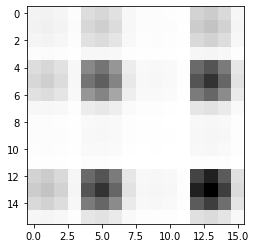

In [49]:
# plot resulting density matrix for small 1D circuit
n = 4
d = 1
mps, qubits, edges, ops, bound = random_1d_mps_bound(n,d,q=2)
qs = [qubits[i] for i in sorted(qubits)]
ol = []
for l in ops:
    ol += [l[i] for i in l]
# print([(i,mps[i].get_all_dangling()) for i in mps])
# result = tn.contractors.greedy(bound+[mps[i] for i in mps]+ol, ignore_edge_order=True)
# print(result.get_tensor().shape)
result = tn.contractors.greedy(bound+[mps[i] for i in mps]+ol, output_edge_order=qs)
state = result.get_tensor().reshape((2**len(qs)))
# print(state)
plt.clf()
plt.imshow(np.abs(np.outer(state,state)), interpolation='nearest',cmap='Greys')
plt.show()

In [48]:
mps, qubits, edges, ops, bound = random_2d_mps_bound(12,12,2,q=2)
len([c for c in qubits])
mps[(10,7)].get_all_edges()
qubits[(10,7)].get_nodes()

[Node
 (
 name : '__unnamed_node__',
 tensor : 
 array([[[-0.35758631+0.32532587j, -0.05347274+0.16949587j,
          -0.11172024-0.45711141j,  0.13145263+0.34552878j],
         [-0.62317213+0.24316592j, -0.44374877-0.65788438j,
           0.04616105+0.02197025j,  0.18244449-0.22403531j]],
 
        [[ 0.5831832 -0.32767443j, -0.69031374-0.3913972j ,
          -0.05109367+0.00172376j,  0.10104213+0.27068118j],
         [-0.47830436+0.07021275j, -0.16483897+0.06645522j,
          -0.28485601+0.37455215j, -0.23523375+0.28519293j]]]),
 edges : 
 [
 Edge('__unnamed_node__'[1] -> '__unnamed_node__'[0] )
 , 
 Edge(Dangling Edge)[1] 
 , 
 Edge('__unnamed_node__'[2] -> '__unnamed_node__'[0] )
 ] 
 ),
 None]

In [150]:
# to demonstrate computation with random 2-site gate
U = ug.rvs(2**2)
V = np.copy(U)
# Ud = np.conjugate(U.T)
U.resize((2,2,2,2))
# Ud.resize((2,2,2,2))
Ud = np.conjugate(U)
Un = tn.Node(U)
Udn = tn.Node(Ud)
a = [tn.Node(np.asarray([np.ones(shape=(1,1)),np.zeros(shape=(1,1))]).swapaxes(0,-1)) for j in range(2)]
b = [tn.Node(np.asarray([np.ones(shape=(1,1)),np.zeros(shape=(1,1))]).swapaxes(0,-1)) for j in range(2)]
a[0][1] ^ a[1][0]
b[0][1] ^ b[1][0]
a[0][-1] ^ Un[0]
a[1][-1] ^ Un[1]
Un[2] ^ Udn[2]
Un[3] ^ Udn[3]
b[0][-1] ^ Udn[0]
b[1][-1] ^ Udn[1]

ia = tn.Node(np.asarray([1]))
oa = tn.Node(np.asarray([1]))
ib = tn.Node(np.asarray([1]))
ob = tn.Node(np.asarray([1]))
a[0][0] ^ ia[0]
a[-1][1] ^ oa[0]
b[0][0] ^ ib[0]
b[-1][1] ^ ob[0]

result = ia @ a[0] @ a[1] @ oa
asdf = np.copy(result.get_tensor())
asdf.resize((4,1))
print(asdf)
print()
print(V)
print()
print(V * asdf)
print()
result = result @ Un 
print(result.get_tensor())
print()
result = result @ Udn @ b[0] @ b[1] @ ib @ ob
print(result.get_tensor())

[[1.]
 [0.]
 [0.]
 [0.]]

[[-0.14738308+0.6403746j   0.17244187-0.50487579j  0.04664299+0.47860511j
   0.07698833+0.21540015j]
 [ 0.61941232+0.31782867j  0.17620252+0.19396525j -0.64809331-0.08793448j
  -0.02115601+0.13578833j]
 [ 0.05127194-0.03030697j -0.10250198+0.37260809j  0.2716383 +0.16475908j
  -0.36105279+0.78474021j]
 [ 0.15268948-0.23801368j  0.24002716-0.66312737j  0.02896808-0.48911359j
  -0.33465883+0.26573799j]]

[[-0.14738308+0.6403746j   0.17244187-0.50487579j  0.04664299+0.47860511j
   0.07698833+0.21540015j]
 [ 0.        +0.j          0.        +0.j          0.        -0.j
  -0.        +0.j        ]
 [ 0.        +0.j         -0.        +0.j          0.        +0.j
  -0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.        +0.j        ]]

[[-0.14738308+0.6403746j   0.04664299+0.47860511j]
 [ 0.17244187-0.50487579j  0.07698833+0.21540015j]]

(1-7.293822100844176e-18j)


In [163]:
# to demonstrate correct orientation of split_node edges
u = random_2_site(q=2)
# print(u.get_tensor())
ud = tn.Node(np.conjugate(u.get_tensor()))
u1, u2, data = tn.split_node(u, left_edges=(u[0], u[2]), right_edges=(u[1], u[3]))
# u2 = tn.Node(np.conjugate(u2.get_tensor()))
# u1 = tn.Node(u1.get_tensor())
# print([u2.get_dimension(e) for e in range(len(u2.get_all_edges()))])
# u1[-1] ^ u2[0]
# result = u1 @ u2
# print('*')
# print(result.get_tensor())
# print('*')
a = [tn.Node(np.asarray([np.ones(shape=(1,1)),np.zeros(shape=(1,1))]).swapaxes(0,-1)) for j in range(2)]
b = [tn.Node(np.asarray([np.ones(shape=(1,1)),np.zeros(shape=(1,1))]).swapaxes(0,-1)) for j in range(2)]
a[0][1] ^ a[1][0]
b[0][1] ^ b[1][0]
a[0][-1] ^ u1[0]
a[1][-1] ^ u2[1]
u1[1] ^ ud[2]
u2[2] ^ ud[3]
b[0][-1] ^ ud[0]
b[1][-1] ^ ud[1]
ia = tn.Node(np.asarray([1]))
oa = tn.Node(np.asarray([1]))
ib = tn.Node(np.asarray([1]))
ob = tn.Node(np.asarray([1]))
a[0][0] ^ ia[0]
a[-1][1] ^ oa[0]
b[0][0] ^ ib[0]
b[-1][1] ^ ob[0]
result = ia @ a[0]
result = result @ u1
print(result.get_dimension(1))
result = result @ a[1] @ oa @ u2 
print(result.get_tensor())
print()
result = result @ ud @ b[0] @ b[1] @ ib @ ob
print(result.get_tensor())

2
[[ 0.04872963+0.52677267j  0.05491512-0.40198427j]
 [-0.41564522-0.23268583j -0.24043327-0.52040095j]]

(0.9999999999999999+1.4303637298823712e-16j)
